Bước 1: Khám phá tập dữ liệu
Thư mục train có chưa 43 thư mục con mỗi thư mục đại diện cho một lớp khác nhau được đánh số thứ tự từ 0 đến 42. sử dụng module OS ta sẽ lặp lại trên tất cả các lớp để kết nối các hình ảnh với nhãn tương ứng của chúng.

Thư viện PIL được sử dụng để chuyển hình ảnh thành một mảng.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import load_model
from sklearn.metrics import accuracy_score
from keras import Input

data = []
labels = []
classes = 43
cur_path = os.getcwd()

#Retrieving the images and their labels
for i in range(classes):
    path = os.path.join(cur_path,'train',str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '\\'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            #sim = Image.fromarray(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

#Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)

Sau đó ta sẽ lưu tất cả các hình ảnh và nhãn của chúng vào lists data và labels.

Chúng ta cần chuyển các lists thành các numpy array để làm đầu vào cho model.

Kích thước của dữ liệu là  (39209, 30, 30, 3), có nghĩa là có 39209 hình ảnh, mỗi ảnh có kích thước 30x30 pixel, số 3 ở cuối thể hiện dữ liệu là hình ảnh màu (giá trị RGB).

Sử dụng phương thức train_test_split () của sklearn để phân chia bộ dữ liệu thành train set và test set.

Sử dụng phương thức to_categorical của keras.utils để xử lý các nhãn của y_train và y_test bằng one-hot encoding.

In [4]:
# In ra kích thước (shape) của dữ liệu đầu vào và nhãn
# data: mảng chứa ảnh hoặc đặc trưng đầu vào
# labels: mảng chứa nhãn tương ứng với mỗi dòng trong data
print(data.shape, labels.shape)

# Chia dữ liệu thành tập huấn luyện (train) và tập kiểm tra (test)
# test_size=0.2 nghĩa là 20% dữ liệu sẽ được dùng làm tập test
# random_state=42 để đảm bảo kết quả chia là cố định (tái hiện được)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# In ra kích thước của từng tập sau khi chia
# X_train, y_train: dữ liệu và nhãn để huấn luyện
# X_test, y_test: dữ liệu và nhãn để kiểm tra mô hình
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Chuyển nhãn từ dạng số nguyên (0–42) sang dạng one-hot encoding
# One-hot encoding biến nhãn thành vector có 43 phần tử (ứng với 43 lớp)
# Ví dụ: nhãn 3 sẽ thành [0, 0, 0, 1, 0, ..., 0]
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

(78418, 30, 30, 3) (78418,)
(62734, 30, 30, 3) (15684, 30, 30, 3) (62734,) (15684,)


Bước 2: Xây dựng mô hình CNN
Để phân loại các hình ảnh thành các danh mục tương ứng, chúng ta sẽ xây dựng mô hình CNN (Convolutional Neural Network). CNN là mô hình tốt nhất cho mục đích phân loại hình ảnh.

Kiến trúc mô hình CNN của chúng ta như sau:

2 Conv2D layer (filter=32, kernel_size=(5,5), activation=”relu”)
MaxPool2D layer ( pool_size=(2,2))
Dropout layer (rate=0.25)
2 Conv2D layer (filter=64, kernel_size=(3,3), activation=”relu”)
MaxPool2D layer ( pool_size=(2,2))
Dropout layer (rate=0.25)
Flatten layer to squeeze the layers into 1 dimension
Dense Fully connected layer (256 nodes, activation=”relu”)
Dropout layer (rate=0.5)
Dense layer (43 nodes, activation=”softmax”)

In [5]:
# Khởi tạo mô hình Sequential (dạng tuần tự)
model = Sequential()

# Thêm lớp đầu vào (Input Layer), shape[1:] tức là (chiều cao, chiều rộng, số kênh màu)
model.add(Input(shape=X_train.shape[1:]))

# Thêm lớp tích chập (convolutional layer) với 32 bộ lọc (filters), kích thước kernel 5x5, hàm kích hoạt ReLU
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))

# Thêm một lớp tích chập nữa với 32 filters, để tăng khả năng trích xuất đặc trưng
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))

# Thêm lớp pooling để giảm kích thước ảnh đặc trưng (feature map)
model.add(MaxPool2D(pool_size=(2, 2)))

# Thêm Dropout để tránh overfitting, loại ngẫu nhiên 25% số neurons
model.add(Dropout(rate=0.25))

# Thêm 2 lớp tích chập với 64 filters và kernel size 3x3
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Pooling và Dropout tương tự như trên
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Flatten chuyển ảnh đặc trưng 2D thành vector 1D để đưa vào lớp fully-connected
model.add(Flatten())

# Thêm một lớp Dense (fully-connected) với 256 neuron và ReLU
model.add(Dense(256, activation='relu'))

# Dropout 50% để giảm overfitting
model.add(Dropout(rate=0.5))

# Lớp đầu ra với 43 neuron tương ứng với 43 lớp, dùng softmax để phân loại
model.add(Dense(43, activation='softmax'))


# Biên dịch mô hình
# loss='categorical_crossentropy': vì ta dùng one-hot encoding
# optimizer='adam': thuật toán tối ưu hóa hiệu quả và phổ biến
# metrics=['accuracy']: đánh giá mô hình dựa trên độ chính xác
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Hiển thị thông tin về kiến trúc mô hình
model


<Sequential name=sequential, built=True>

Sau khi xây dựng kiến trúc mô hình, chúng ta sẽ huấn luyện mô hình bằng cách sử dụng model.fit (). Chúng ta hãy thử với batch size là 32 và 64. nhận thấy mô hình hoạt động tốt hơn với batch size là 64. và sau 15 epochs độ chính xác đã được ổn định.

BIÊN DỊCH ĐỂ

Tính toán mất mát (loss) – tức là đo độ sai lệch giữa dự đoán và giá trị thật.

Cập nhật trọng số – thông qua trình tối ưu hóa (optimizer).

Đánh giá hiệu suất mô hình – dựa trên một hoặc nhiều chỉ số đánh giá (metrics) như accuracy.

In [6]:
epochs = 2
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/2
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - accuracy: 0.3660 - loss: 2.5706 - val_accuracy: 0.9177 - val_loss: 0.3046
Epoch 2/2
1961/1961 ━━━━━━━━━━━━━━━━━━━━ 76s 39ms/step - accuracy: 0.8361 - loss: 0.5369 - val_accuracy: 0.9637 - val_loss: 0.1325


Mô hình của chúng ta đã đạt đến độ chính xác (val_accuracy) ~ 95% trên tập training set. Sử dụng matplotlib để vẽ biểu đồ tương quan giữa độ chính xác và sự mất mát.

In [8]:
model.save("traffic_classifier111111.h5")

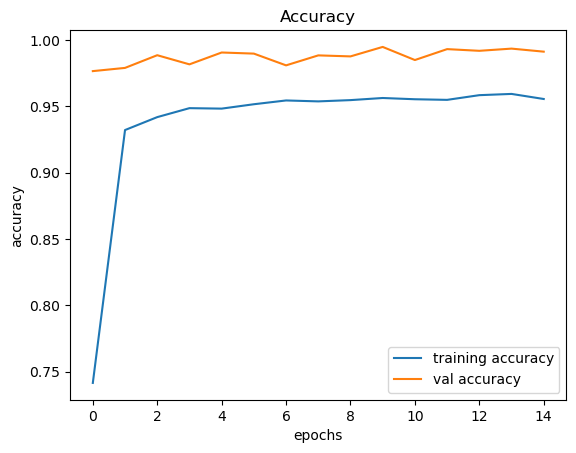

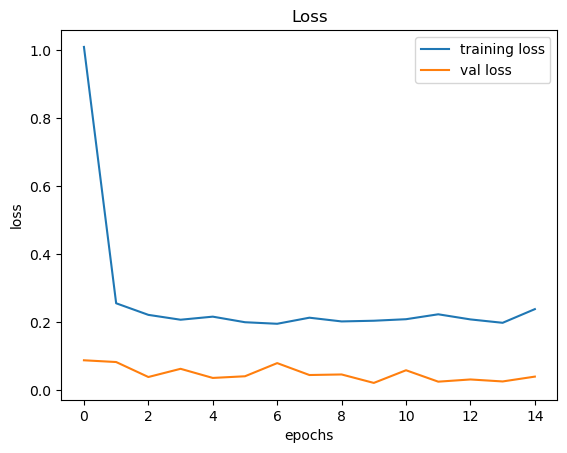

In [8]:
#plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')      # Accuracy trên tập huấn luyện
plt.plot(history.history['val_accuracy'], label='val accuracy')      # Accuracy trên tập validation
plt.title('Accuracy')                                                # Tiêu đề biểu đồ
plt.xlabel('epochs')                                                 # Trục X là số epoch
plt.ylabel('accuracy')                                               # Trục Y là độ chính xác
plt.legend()                                                         # Hiển thị chú thích
plt.show()                                                           # Hiển thị biểu đồ


plt.figure(1)
plt.plot(history.history['loss'], label='training loss')              # Loss trên tập huấn luyện
plt.plot(history.history['val_loss'], label='val loss')              # Loss trên tập validation
plt.title('Loss')                                                    # Tiêu đề biểu đồ
plt.xlabel('epochs')                                                 # Trục X là số epoch
plt.ylabel('loss')                                                   # Trục Y là giá trị loss
plt.legend()                                                         # Hiển thị chú thích
plt.show()                                                           # Hiển thị biểu đồ

In [12]:
# Đường dẫn hiện tại
cur_path = os.getcwd()

# Đường dẫn tới tệp Test.csv
test_csv_path = os.path.join(cur_path, 'Test123.csv')

# Đọc dữ liệu từ Test.csv
y_test = pd.read_csv(test_csv_path)

# Lấy nhãn và đường dẫn ảnh
labels = y_test["ClassId"].values
imgs = [os.path.join(cur_path, img) for img in y_test["Path"].values]

# Xử lý ảnh
data = []
for img in imgs:
    if not os.path.exists(img):
        print(f"File not found: {img}")
    else:
        try:
            image = Image.open(img)
            image = image.resize((30, 30))
            data.append(np.array(image))
        except Exception as e:
            print(f"Error loading image {img}: {e}")

# Chuyển đổi dữ liệu thành numpy array
X_test = np.array(data)

# Load mô hình đã lưu
model = load_model("traffic_classifier30_64.h5")

# Dự đoán
pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)

# Đánh giá độ chính xác
accuracy = accuracy_score(labels, pred_classes)
print(f"Test Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Test Accuracy: 1.0
